# Analysis Report

### Executive Summary  

The Overall performance of Jumpman23 in New York during October 2014 is positive. Delivery frequency increased as the month progressed from an average of 167 orders per day in the first two weeks, to 180 orders per day the final two weeks. Customers are concentrated in Manhattan, with a small number of deliveries in the adjacent boroughs of Queens and Brooklyn. In this month, we have 3192 unique customers. However, the returning customers as only 30.6%. To improve our business performance, we need to develop campaigns and customer loyalty program to improve retention.

### Objective:
1. Understand the market performance on Jumpman23’s New York City delivery data and find growth opportunities.
2. Identify the potential data integrity issues, their impacts on the analysis, and provide a solution    


### Data Integrity issue:  
1. Missing and duplicated records exists, and can be fixed with database constraints.
2. No suspicious behavior in location, distance, and speed of vehicle
3. Inappropriate (Negative) value in waiting time between order and pickup

* collected date range of our data is insufficient to conduct analysis
* Serveral of the biggest resturants have multiple stores in different areas. Some customers make order from the stores that are far away. 


### Approach
* Data importing and preprocessing
* Descriptive analysis and feature engineering
* Data Integrity Check
    - Issue
    - Impact on Analysis
    - Recommendation (Database constraints, Pattern Detection functions, etc)



### Suggestions & Next Steps

1. Fix the data integrity issues.  Stored data in database with rules.
2. Collect price data for future marketing campaigns/ discount strategy.
3. Reduce the preparation time by purchasing the items in advance. Build models for the Jumpman allocation.
4. Recommend customers with closest store.


# Data importing and preprocessing

## Load packages

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import seaborn as sns
import json
from urllib.request import urlopen,urlretrieve
#from shapely.geometry import shape as Shape, Point

from datetime import datetime,date,timedelta


import plotly.offline as py 
import plotly.graph_objs as go
import cufflinks as cf
import plotly.figure_factory as ff


cf.go_offline()
py.init_notebook_mode(connected=True)

## Load data

In [2]:
df = pd.read_csv('analyze_me2.csv',
                 parse_dates= ['when_the_delivery_started',
                              'when_the_Jumpman_arrived_at_pickup',
                              'when_the_Jumpman_left_pickup',
                              'when_the_Jumpman_arrived_at_dropoff'],   # convert str into date_time format
                 infer_datetime_format = True,
                 converters = {'how_long_it_took_to_order':pd.to_timedelta})  # find during of the feature 
df_copy=df.copy()

# Make column name concise
df=df.rename(columns={"when_the_delivery_started": "delivery_start", 
                   "when_the_Jumpman_arrived_at_pickup": "pickup_arrival",
                   "when_the_Jumpman_left_pickup": "pickup_left",
                   "when_the_Jumpman_arrived_at_dropoff": "dropoff_arrival"})  

In [3]:
description_dict={'delivery_id':'orders',
              'pickup_place':'pickup places',
              'customer_id':'customers',
              'jumpman_id':'delivers',
              'item_name':'items',
              'place_category':
              'place categories'}

for col, description in description_dict.items():
    print('Number of unique %s:'% description,len(df[col].unique()))

Number of unique orders: 5214
Number of unique pickup places: 898
Number of unique customers: 3192
Number of unique delivers: 578
Number of unique items: 2278
Number of unique place categories: 58


## Features: Time
- Pick up wait time: the time between order is placed and the jumpman arrived
- In store wait time: the time between jumpman arrived and the item is prepared.
- Total delivery time: the time between order is placed and customer is getting the item

In [4]:
# three types
df['pick_up_wait_time']  = df.pickup_arrival- df.delivery_start
df['in_store_wait_time']=df.pickup_left-df.pickup_arrival
df['total_delivery_time']= df.dropoff_arrival-df.delivery_start

time_group= ['how_long_it_took_to_order','pick_up_wait_time','in_store_wait_time','total_delivery_time']

In [5]:
# Convert the field into minutes
for col in time_group:
    df[col]=df[col].apply(lambda x:round(x.seconds/60,1))

In [6]:
# df['month']= df.delivery_start.dt.month    all records in month
df['week']=df.delivery_start.dt.week
df['day']=df.delivery_start.dt.day

## Features: Distance & Speed
The later one code chunk is sourceed from: http://jm23-nyc.herokuapp.com/#scooter

In [7]:
from shapely.geometry import shape as Shape, Point
#Returns feature for coordinates using dict of feature:Shape
def getFeatureforPoint(shapeDict,lon,lat):
    point = Point(lon,lat)
    for feature, shape in shapeDict.items():
        if shape.contains(point):
            return(feature)

#Geodata from NYC OpenData 
boroughBoundaries = urlopen('https://data.cityofnewyork.us/resource/7t3b-ywvw.json').read().decode('utf-8')
boroughDict = { borough['boro_name']: Shape(borough['the_geom']) for borough in json.loads(boroughBoundaries)}

#NTA (Neighbordhood Tabulation Area) Boundaries 
ntaBoundaries = urlopen('https://data.cityofnewyork.us/resource/93vf-i5bz.json').read().decode('utf-8')
ntaDict = { nta['ntaname']: Shape(nta['the_geom']) for nta in json.loads(ntaBoundaries)}

#Add borough and NTA for each pickup/dropoff location
df['pickup_borough'] = df.apply(lambda row: getFeatureforPoint(boroughDict,  row['pickup_lon'], row['pickup_lat']), axis=1)
df['dropoff_borough'] = df.apply(lambda row: getFeatureforPoint(boroughDict, row['dropoff_lon'], row['dropoff_lat']), axis=1)
df['pickup_NTA'] = df.apply(lambda row: getFeatureforPoint(ntaDict,  row['pickup_lon'], row['pickup_lat']), axis=1)
df['dropoff_NTA'] = df.apply(lambda row: getFeatureforPoint(ntaDict, row['dropoff_lon'], row['dropoff_lat']), axis=1)


location_group = ['pickup_borough','dropoff_borough','pickup_NTA','dropoff_NTA']

In [8]:
from math import radians, cos, sin, asin, sqrt
def geodistance(lng1,lat1,lng2,lat2):
    # turn longitude, latitude into Radian measure
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) 
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    distance=2*asin(sqrt(a))*6371*1000 # Earth Radius，6371km
    distance=round(distance/1000,3)
    return distance

In [9]:
distance_col=[] 
for i in range(df.shape[0]):
    lat1,lon1,lat2,lon2=(df.pickup_lat[i],df.pickup_lon[i],df.dropoff_lat[i],df.dropoff_lon[i])
    distance_col.append(geodistance(lat1,lon1, lat2,lon2))

    
df['distance']=distance_col
df['speed']=df.distance/(df.total_delivery_time/60)   # miles per hour

# Market Analysis
* Market Analysis:
    - What's happening in our delivery business in New York?
* Business Partners: Customers, jumpmans, restaurants
* Delivery

## Market Analysis
	- Growth
		○ Orders
		○ New customers
		○ Stores
	- Metric comparison
		○ Avg time
			§ Order
			§ Transit
			§ Pickup 
    - Num of orders taken

In [10]:
agg_function=['count','sum']
item_quantity_week = pd.pivot_table(df,index='week',
                                    aggfunc=agg_function,
                                    values=['item_quantity'],
                                    margins=True)
item_quantity_week[item_quantity_week.index==40]=item_quantity_week[item_quantity_week.index==40]*7/5
item_quantity_week[item_quantity_week.index==44]=item_quantity_week[item_quantity_week.index==44]*7/4

**Since we only have 5 days of the week 40, and 4 days of week 44, we adjust the value using the simple average to simulate an adjusted order quantity**

In [11]:
round(item_quantity_week[:-1],0)

,count,sum
,item_quantity,item_quantity
week,,
40,1049.0,1361.0
41,1081.0,1343.0
42,1159.0,1463.0
43,1164.0,1409.0
44,1050.0,1306.0


In [12]:
flattened = pd.DataFrame(round(item_quantity_week[:-1],0).to_records())

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=flattened['week'],
    y=flattened.iloc[:,1],
    name="Total number of delivery"       # this sets its legend entry
))

fig.add_trace(go.Scatter(
    x=flattened['week'],
    y=flattened.iloc[:,2],
    name="Total number of items ordered"       # this sets its legend entry
))

fig.update_layout(
    title="Market Performance",
    xaxis_title="Week",
    yaxis_title="Quantity",

)

fig.show()

## Customers Analysis
Overall performance in New York for October 2014 is positive. Delivery frequency increased as the month progressed from an average of 167 orders per day in the first two weeks, to 180 orders per day the final two weeks. Deliveries were primarly concentrated in Manhattan, with a small number of deliveries in the adjacent boroughs of Queens and Brooklyn. There were 3192 unique customers, but the percentage of customers who used Jumpman23 more than once was only 30.6%. Improving customer retention and increasing delivery efficiency are my recommendations to continue growth in New York.


**Increasing Customer Rentention**
In Oct 2014, customers use the Jumpman23 service in a predictable manner. Order frequency increases on the weekends, particularly on Sunday which has the highest order volume compared to the rest of the week. Order times are centered around lunch and dinner consistently throughout the week as well. Offering delivery deals and sending notifications to existing customers before these peak days/hours could incentivize customers to use Jumpman23’s service again.

The first chart below illustrates Jumpman23’s growth throughout the month of October, and also highlights the increased usage of service on the weekends. The noticeble spikes of service are on Sunday of each week. The second graph shows the distribution of orders during the hours of the day.

In [14]:
sub_df=df[["customer_id","week"]]

set_40=set(sub_df[sub_df.week==40].customer_id)
set_41=set(sub_df[sub_df.week==41].customer_id)
set_42=set(sub_df[sub_df.week==42].customer_id)
set_43=set(sub_df[sub_df.week==43].customer_id)
set_44=set(sub_df[sub_df.week==44].customer_id)


number=[len(set(set_40) & set(set_41))/len(set_40),
len(set(set_40) & set(set_42))/len(set_40),
len(set(set_40) & set(set_43))/len(set_40),
len(set(set_40) & set(set_44))/len(set_40)]



In [15]:
print("If the time it took to order is long, I believe there's space for the website to optimize the store experience")
df.groupby('pickup_place').total_delivery_time.describe()['mean'].sort_values(ascending=False).tail(15)

If the time it took to order is long, I believe there's space for the website to optimize the store experience


pickup_place
Postmates                       18.0
Whisker's Holistic Pet Care     18.0
The Tumi Store                  17.0
Cowboy Boots shoe Repair        17.0
Holey Cream                     17.0
Lupe's East LA Kitchen          17.0
Sephora                         17.0
Subway                          17.0
UVA Wines & Spirits             16.0
Charley Mom                     14.0
Brooklyn Roasting Company       13.5
384 Broome St                   13.0
300 North End Ave and Warren    13.0
Milano Market                   11.0
T & R Pizza                      4.0
Name: mean, dtype: float64

**When customers make an order?**

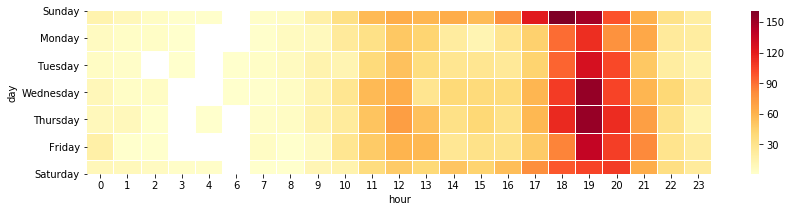

In [16]:
from matplotlib import pyplot
pyplot.figure(figsize=(14, 3))
df['day'] = df.delivery_start.dt.weekday_name
df['hour'] = df.delivery_start.dt.hour
d = df.groupby(['day','hour']).size().reset_index(name='count').pivot('day','hour','count')
d.index = pd.CategoricalIndex(d.index, categories= ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
d.sort_index(level=0, inplace=True)
sns.heatmap(d,linewidths=.004,cmap='YlOrRd')

In [17]:
df.groupby('dropoff_borough').size()/df.shape[0]

dropoff_borough
Brooklyn     0.039779
Manhattan    0.959385
Queens       0.000836
dtype: float64

In [18]:
print('Dropoffs by neighborhood')
df.groupby('dropoff_NTA').size().sort_values(ascending=False).reset_index(name='count').head(10)

Dropoffs by neighborhood


,dropoff_NTA,count
0,SoHo-TriBeCa-Civic Center-Little Italy,823
1,West Village,806
2,Hudson Yards-Chelsea-Flatiron-Union Square,787
3,Midtown-Midtown South,470
4,Upper East Side-Carnegie Hill,456
5,East Village,260
6,Battery Park City-Lower Manhattan,241
7,Lenox Hill-Roosevelt Island,222
8,Lincoln Square,217
9,Murray Hill-Kips Bay,217


In [19]:
print('Cross-borough deliveries')
df[df.dropoff_borough != df.pickup_borough].groupby(['pickup_borough','dropoff_borough']).size() \
    .sort_values(ascending=False).reset_index(name='count')

Cross-borough deliveries


,pickup_borough,dropoff_borough,count
0,Manhattan,Brooklyn,47
1,Brooklyn,Manhattan,26
2,Manhattan,Queens,3
3,Brooklyn,Queens,1


### Jumpman 

In [20]:
jumpman_delivery_count=df.groupby('jumpman_id').size().sort_values(ascending=False)


value=round(len(jumpman_delivery_count[jumpman_delivery_count<=5])/len(jumpman_delivery_count),2)
print("In total, we have {} number of jumpmen".format(len(jumpman_delivery_count)))
print("{} percentage of Jumpman make delivery <= 5 times".format(value))

In total, we have 578 number of jumpmen
0.47 percentage of Jumpman make delivery <= 5 times


## Delivery Analysis

In [21]:
df[time_group].head(10)
print("we can see there's some of the records, indicating delivery person arrived at the store before order exist")

we can see there's some of the records, indicating delivery person arrived at the store before order exist


### Issue 1: 

In [22]:
agg_function=['count','sum']
item_quantity_vehicle = pd.pivot_table(df,index='vehicle_type',
                                    aggfunc=['count'],
                                    values=['item_quantity'],
                                    margins=True)



item_quantity_vehicle=pd.DataFrame(item_quantity_vehicle.to_records()).T

In [23]:
df['total_delivery_time']=round(df['total_delivery_time'],0).astype(int)
df_delivery=df[['vehicle_type','total_delivery_time']]

In [24]:
y0 = list(df_delivery[df_delivery.vehicle_type=='bicycle'].total_delivery_time)
y1 = list(df_delivery[df_delivery.vehicle_type=='car'].total_delivery_time)
y2 = list(df_delivery[df_delivery.vehicle_type=='walker'].total_delivery_time)
y3 = list(df_delivery[df_delivery.vehicle_type=='van'].total_delivery_time)
y4 = list(df_delivery[df_delivery.vehicle_type=='scooter'].total_delivery_time)
y5 = list(df_delivery[df_delivery.vehicle_type=='truck'].total_delivery_time)
y6 = list(df_delivery[df_delivery.vehicle_type=='motorcycle'].total_delivery_time)

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='bicycle',
                     marker=dict(color='rgb(8,81,156)',outliercolor='rgba(219, 64, 82, 0.6)')))

fig.add_trace(go.Box(y=y1, name = 'car',
                marker_color = 'grey'))
fig.add_trace(go.Box(y=y2, name = 'walker',
                marker_color = 'grey'))
fig.add_trace(go.Box(y=y3, name = 'van',
                marker_color = 'grey'))
fig.add_trace(go.Box(y=y4, name = 'scooter',
                marker_color = 'grey'))
fig.add_trace(go.Box(y=y5, name = 'truck',
                marker_color = 'grey'))
fig.add_trace(go.Box(y=y6, name = 'motorcycle',
                marker_color = 'grey'))

fig.show()

## Visualizations

In [25]:

v1= np.nanquantile(df.in_store_wait_time,q=0.90)
v2= np.nanquantile(df.pick_up_wait_time,q=0.90)
v3= np.nanquantile(df.how_long_it_took_to_order,q=0.90)
sub_df=df[(df.in_store_wait_time<=v1) & (df.pick_up_wait_time<=v2) & (df.how_long_it_took_to_order<=v3)]

In [26]:
sub_df[['how_long_it_took_to_order','pick_up_wait_time','in_store_wait_time']].iplot(kind='box')

In [27]:
df[df.pick_up_wait_time>v2]['delivery_start']

2      2014-10-28 21:39:00
6      2014-10-10 21:08:00
7      2014-10-06 23:20:00
73     2014-10-18 17:11:00
83     2014-10-03 18:15:00
               ...        
5936   2014-10-28 21:32:00
5947   2014-10-20 13:02:00
5953   2014-10-12 19:48:00
5972   2014-10-15 20:23:00
5981   2014-10-27 20:25:00
Name: delivery_start, Length: 534, dtype: datetime64[ns]

In [28]:
df['hour']=df.delivery_start.apply(lambda x:x.hour)

In [29]:
graph1=df.hour.value_counts()

In [30]:

graph1.iplot(kind='bar', title='Number of order per hour')

In [31]:
off_peak_hours_percentage= round(graph1[graph1.index.isin([1,2,3,4,6])].sum()/graph1.sum()*100,2)
off_peak_hours_percentage

1.29

**Turns out, in Oct 2014, all the orders during off_peak hour represents 1.2% of total orders.<br>
That proportion of market might not be as profitable if Jumpman23's business won't growth tremendously**


In [32]:
df.groupby('hour').mean()['total_delivery_time'].iplot(kind='bar', title='Average Delivery time by hour')

# Data Integrity

**Description**: Delivery data (Completed) is saved in Database, containing delivery times, locations, ids to identify customer/delivery/jumpman information

1. Data Sanity Check
2. Data Integrity Check 
    - Spot inconsistency
    - Explains why that might be a issue
    - Recommendation to ensure data integrity

**Recommendation**:
1. **Adding primary key constraints** to backend Database
- Set **column specific constraints** from data collection to database <br>
- (Option) Use a data pipeline to clean and process the data. Since I don't have the access to database



## Duplicates

**Issue**: Existing duplicates delivery_id, it violent database consistency issue. <br>
**Impact on Analysis**: 


**Repeated values for single orders**: When a customer ordered multiple items in a single order, there were multiple rows with one for each item. This could create potential problems with delivery level analysis. I removed the duplicates as explained in the detailed analysis tab.


In [33]:
duplicate_record_count=df[df.duplicated()].shape[0]
print("There are {} duplicated records in our data".format(duplicate_record_count))

print("Delivery ID is not a unique identifier, which has {} duplicated ones ".format(
df.delivery_id.duplicated().sum()))

There are 16 duplicated records in our data
Delivery ID is not a unique identifier, which has 769 duplicated ones 


In [34]:
import pymysql
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Database name is Jumpman
SQL_DB = "Jumpman"

# Define a function to create SQL database and table
def create_sql_table(SQL_TABLE, SQL_TABLE_DEF):
    try:
        # Connect to server:
        conn = pymysql.connect(host='localhost', user = 'root', password = '')
        cursor = conn.cursor()
        
        # SQL query to create database:
        query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB + ";"
        cursor.execute(query)
        
        # SQL query to create table:
        query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";"
        cursor.execute(query)
        
        # Close cursor and connect:
        cursor.close()
        conn.close()
        return

    except IOError as e:
        print(e)


In [35]:
# Define table
SQL_TABLE = "Jumpman23_Delivery"
SQL_TABLE_DEF = "(" + \
            "delivery_id CHAR(12) NOT NULL PRIMARY KEY" + \
            ", customer_id CHAR(12) NOT NULL" + \
            ", jumpman_id CHAR(12) NOT NULL" + \
            ", vehicle_type VARCHAR(12)" + \
            ", pickup_place VARCHAR(30)" + \
            ", place_category VARCHAR(30)" + \
            ", item_name VARCHAR(30)" + \
            ", item_quantity INT(2)" + \
            ", item_category_name VARCHAR(30)" + \
            ", how_long_it_took_to_order DATETIME" + \
            ", pickup_lat Decimal(9,6)"+\
            ", pickup_lon Decimal(9,6)" +\
            ", dropoff_lat Decimal(9,6)" +\
            ", dropoff_lon Decimal(9,6)" +\
            ", when_the_delivery_started DATETIME" + \
            ", when_the_Jumpman_arrived_at_pickup DATETIME" + \
            ", when_the_Jumpman_left_pickup DATETIME" + \
            ", when_the_Jumpman_arrived_at_dropoff DATETIME"\
            ")"

# Call function to create in MySql
create_sql_table(SQL_TABLE, SQL_TABLE_DEF)

**Write SQL insert query:**
insert_query = "INSERT INTO " + SQL_TABLE + \  <br>
"(delivery_id, customer_id, jumpman_id, vehicle_type, \  <br>
       pickup_place, place_category, item_name, item_quantity, \ <br>
       item_category_name, how_long_it_took_to_order, pickup_lat, \ <br>
       pickup_lon, dropoff_lat, dropoff_lon, when_the_delivery_started,\ <br>
       when_the_Jumpman_arrived_at_pickup, when_the_Jumpman_left_pickup,\ <br>
       when_the_Jumpman_arrived_at_dropoff)" + \ <br>
" VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s);" <br>

**Insert the values list into MySql table:**
try: <br>
    conn = pymysql.connect(host='localhost', user = 'root', password = '', database = SQL_DB) <br>
    cursor = conn.cursor() <br>
    
    cursor.executemany(insert_query, df_copy) <br>
    conn.commit() <br>
    cursor.close() <br>
    conn.close() <br>
    
except IOError as e: <br>
    print(e) <br>

**Later, the duplicate record problem will no longer exists. We can also add column constraints for database.**


## Missing value
**issue**: the data set contains 8% [8000] missing values, from 100 K records <br>
**Impact on analysis (low)**: lower data quality since Jumpman's order information is not complete. <br>
**Treatment**: by spliting the missing data into missing at/not at random, we should adjust different treatments.



**1.Values Missing Not at random  (MNAR)**<br>
Group 1: Item Category, item name, item quantity  <br>
Group 2: pickup_arrival,pickup_left

**Reason**:  <br>
Group1: stores& resturants update their shopping cart or item category didn't pass the system.<br>
Group2: the Jumpmans forget to check or update their status

**Recommendation**: 
The app can either automatically collect the pickup info, or design a feature to notify and remind jumpman to keep that record




**2.Value Missing at Random(MAR)** <br>
"How long it took to order" have around 50% of missing values. 

**Recommendation**:
use random forest regressor to fill the missing value


In [36]:
missing_rate=sum(df_copy.isna().sum())/(df_copy.shape[0]*df_copy.shape[1])
print("Missing rate for the dataset is ", round(missing_rate*100,2),"%")

Missing rate for the dataset is  8.0 %


In [37]:
na_columns=df.isna().sum().sort_values(ascending=False)
na_columns[na_columns>0]

how_long_it_took_to_order    2945
item_quantity                1230
item_name                    1230
item_category_name           1230
place_category                883
in_store_wait_time            550
pickup_arrival                550
pickup_left                   550
pick_up_wait_time             550
dtype: int64

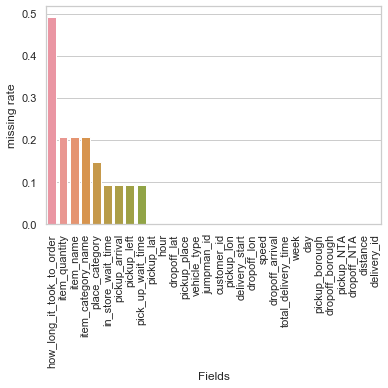

In [38]:
from matplotlib import pyplot as plt
missing_values = (na_columns/df.shape[0]).to_frame()
missing_values.columns = ['missing rate']
missing_values.index.names = ['Fields']
missing_values['Fields'] = na_columns.index

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Fields', y = 'missing rate', data=missing_values)
plt.xticks(rotation = 90)
plt.show()



### Values Missing Not at random  (MNAR)<br>


### Value Missing at Random(MAR) - How long it take to order
Filled the missing value using Random Forest Regressor

In [39]:
# Find variables to fit the how_long_it_took_to_order
df.apply(lambda x: x.nunique())

delivery_id                  5214
customer_id                  3192
jumpman_id                    578
vehicle_type                    7
pickup_place                  898
place_category                 57
item_name                    2277
item_quantity                  11
item_category_name            767
how_long_it_took_to_order     252
pickup_lat                   1210
pickup_lon                   1178
dropoff_lat                  2841
dropoff_lon                  2839
delivery_start               4620
pickup_arrival               4220
pickup_left                  4222
dropoff_arrival              4611
pick_up_wait_time              80
in_store_wait_time             84
total_delivery_time           137
week                            5
day                             7
pickup_borough                  3
dropoff_borough                 3
pickup_NTA                     39
dropoff_NTA                    45
distance                     2419
speed                        4920
hour          

In [40]:
dummy_variables=['vehicle_type','place_category','pickup_place','pickup_borough','dropoff_borough','week']

In [41]:
def get_dummies_for_dataframe(df,dummy_list):
    
    for var in dummy_variables:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df[var], prefix=var)
        df = pd.concat([df,cat_list], axis = 1)
        df = df.drop(var, 1)
    return df

In [42]:
df_copy2=df[['how_long_it_took_to_order','vehicle_type','place_category','item_quantity','pickup_place','pickup_borough','dropoff_borough','week']].copy()
df_copy2=get_dummies_for_dataframe(df_copy2,dummy_list=dummy_variables)
df_copy2['item_quantity']=df_copy2['item_quantity'].fillna(1)

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

In [44]:
train=df_copy2[~df_copy2.how_long_it_took_to_order.isna()]
train_X=train[[col for col in train.columns if col!='how_long_it_took_to_order']]
train_y=train['how_long_it_took_to_order']

test=df_copy2[df_copy2.how_long_it_took_to_order.isna()]

test_X=test[[col for col in test.columns if col!='how_long_it_took_to_order']]

In [45]:
rf.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [46]:
rf.predict(test_X)

array([5.31860011, 5.72535   , 5.31860011, ..., 7.14001667, 5.461275  ,
       4.23664286])

## Geological Data Integrity

In [47]:
df[['vehicle_type','speed']].groupby('vehicle_type').mean()

,speed
vehicle_type,
bicycle,1.713041
car,2.083660
motorcycle,2.215707
scooter,1.860443
truck,2.429172
van,1.860774
walker,1.845526


[Text(0.5, 1.0, 'Delivery Distance in MemoryErroriles')]

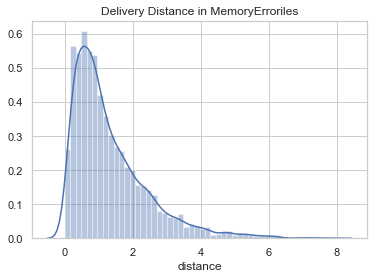

In [48]:
x = df.distance.sort_values()
sns.distplot(x).set(title = 'Delivery Distance in MemoryErroriles')

**From current observation, after I double check with Google map's distance, our Geological data has no data integrity issue.**

In [49]:
print("The fastest delivery speed is {} miles per hour, which is reasonable in NY city, since most delivery are in a city with busy traffic".format(round(df.speed.max(),2)))

The fastest delivery speed is 23.26 miles per hour, which is reasonable in NY city, since most delivery are in a city with busy traffic


##  Inappropriate value 
**Issue1**: Inappropriate (Negative) value in waiting time between order and pickup
Two possible reason.
    1. the Jumpman forget to enter the location 
    2. the Jumpman arrived at the store before a customer make the order

**Recommendation**: We need further validation on existing dataset. 



**Issue2**: We have way too many categories of items to keep track on. <br>
**Reason**: fewer distinctive values results in high quality data. <br>
**Recommended action**: I applied clustering technique and text preprocessing to identify food categories.<br>


### Issue1: Negative pickup time

In [50]:
sub_df=df[['jumpman_id','delivery_start','pickup_arrival', 'pickup_left', 'dropoff_arrival']]

In [51]:
inappropriate1=sub_df[sub_df.pickup_arrival<sub_df.delivery_start]
inappropriate1.head()

,jumpman_id,delivery_start,pickup_arrival,pickup_left,dropoff_arrival
2,132725,2014-10-28 21:39:00,2014-10-28 21:37:00,2014-10-28 21:59:00,2014-10-28 22:04:00
6,124897,2014-10-10 21:08:00,2014-10-10 21:07:00,2014-10-10 21:29:00,2014-10-10 21:40:00
7,79847,2014-10-06 23:20:00,2014-10-06 23:17:00,2014-10-07 00:03:00,2014-10-07 00:09:00
73,28765,2014-10-18 17:11:00,2014-10-18 17:10:00,2014-10-18 17:37:00,2014-10-18 18:13:00
83,39202,2014-10-03 18:15:00,2014-10-03 18:14:00,2014-10-03 18:40:00,2014-10-03 18:56:00


In [52]:
print("We have {} cases of Jumpman arrival at store before the delivery start".format(inappropriate1.shape[0]))

We have 396 cases of Jumpman arrival at store before the delivery start


In [53]:
inappropriate2=sub_df[sub_df.pickup_left<sub_df.delivery_start]

print("We have {} cases of Jumpman left the pick up place before the delivery start".format(inappropriate2.shape[0]))

We have 2 cases of Jumpman left the pick up place before the delivery start


**For example, jumpman with Id "66416" arrived at store 9 times before the delivery start**

In [54]:
problematic_jumpman_records=inappropriate1.groupby('jumpman_id').size().sort_values(ascending=False)

In [55]:
value=problematic_jumpman_records[problematic_jumpman_records>1]
problematic_jumpman_id=value.index
print("It turns out, there are {} jumpmans have more than one suspicious cases, their average is 3".\
      format(len(value),
            round(sum(value)/len(value))
            ))
value_df=value.to_frame()

It turns out, there are 93 jumpmans have more than one suspicious cases, their average is 3


In [56]:
problematic_all_delivery=df[df.jumpman_id.isin(problematic_jumpman_id)].groupby('jumpman_id').size().to_frame()

result = pd.merge(problematic_all_delivery, value_df, on=['jumpman_id'])

In [57]:
result.columns=['Total_delivery','Problem_delivery']
result['Problematic_percentage']=round((result.Problem_delivery/result.Total_delivery)*100,2)

In [58]:
result.sort_values('Problematic_percentage',ascending=False)

,Total_delivery,Problem_delivery,Problematic_percentage
jumpman_id,,,
105762,2,2,100.00
157695,2,2,100.00
30388,2,2,100.00
62075,2,2,100.00
130705,4,3,75.00
...,...,...,...
3296,57,3,5.26
61900,61,3,4.92
43955,48,2,4.17


**This is a serious data integrity issue that could , we need further investigation on the root cause of the issue**

## Picking the right Store
**Issue**:
Serveral of the biggest resturants have multiple stores in different areas. Some customers make order from the stores that are far away. 

**Reason**: customer might make order by search the store name, and pick the wrong address.

**Recommended action**: use a distance measure to match Top stores& customers, selecting your closest spot. functions includes:
- Advice customer to enter correct zipcode
- Update in-app/ website search results by distance set as default



## Missing Revenue Data  (Data Collection)

**Issue**: not sufficient information to make deeper analysis.

**Reason**: In the food delivery company, there are multiple KPIs to look over. For users, we have KPI for driver, restaurant, and customers. For business, we have performance indicator for Revenue and cost. The current data lack pricing data.

    Some examples are:
    Driver & Restaurant KPIs:
    - Average Order Duration. 
    - Percentage of Driver Is On Order / Idle. 
    - Number Of Support Tickets.

    Customer KPIs:
    - Churn Rate. 
    - Customer Lifetime Value (CLV) 
    - Net Promoter Score (NPS)

**Recommendation**: 
Collect pricing data of each order. So we could have a better understanding of revenue generated over a given period.

## Inappropriate Data Range (Data Collection)
**Issue**: collected date range of our data is insufficient to conduct analysis <br>

**Impact on Analysis**: Since customers behavior have a clear weekly cyclical trend, we should collect at least a month of data to be the unit of analysis.
Pickup waiting time less than 0, indicating the jumpman arrived at store before order is placed.

**Recommended action**:
Connect Python to backend SQL database, design relevant queries as fixed schema. Example:
- the data collected should be in-line with product life cycle.
- Set a schema to retrieve data that could be used to derive insights.


In [63]:
# df.to_csv("cleaned_data.csv")


### Case: Shake Shack

In [59]:
Shake_Shack_orders=df[df.pickup_place=="Shake Shack"]

In [60]:
df.groupby('pickup_place').size().sort_values(ascending= False)[:2]

pickup_place
Shake Shack          311
Momofuku Milk Bar    186
dtype: int64

In [61]:
print("Let's have a look at Shake Shack's stores at different locations")
Shake_Shack_orders[['pickup_lat','pickup_lon']].drop_duplicates()

Let's have a look at Shake Shack's stores at different locations


,pickup_lat,pickup_lon
9,40.758457,-73.989140
22,40.780826,-73.976483
48,40.715279,-74.014860
64,40.682770,-73.976532
137,40.692146,-73.988865
177,40.779126,-73.954905
338,40.740884,-73.988199
